Pratik Dhameliya(19131969)

In [22]:
import math
import markdown
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt
# Create a custom legend
from matplotlib.patches import Patch
import geopandas as gpd
import plotly.express as px
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool

## TASK 1

In [23]:
# Read the Markdown file
md_file = '/meta-data.md'
with open(md_file, 'r') as f:
    md_data = f.read()

# Print the contents of the Markdown file
print(md_data)

# traffic data
The files

agency.txt
routes.txt
shapes.txt
stops.txt
stop_times.txt
trips.txt

are in standard CSV format and they form a subset of a database of connected tables according to the General Transit Feed Specification (GTFS) specification, see here:
https://gtfs.org/documentation/schedule/reference/
The describe part of the public transport network in Schleswig-Holstein. Only the included tables are needed for the exam.
The original data is provided by the public transport network service of Schleswig-Holstein:
https://opendata.schleswig-holstein.de/dataset/fahrplandaten

# schematic map of germany
Some lines giving a schematic overview of germany are contained in the file
vg2500.npz
The line collections are just stored as unnamed arrrays of shape [2,N] and they can be imported and plotted via

tmp=np.load("vg2500.npz")
poslist=[tmp[k] for k in tmp.keys()]
del tmp

for pos in poslist:
    plt.plot(*pos,c="#808080")

You can use these lines to provide some orientation in a 

In [24]:
agency = pd.read_csv('/agency.txt')
stops = pd.read_csv('/stops.txt')
routes = pd.read_csv('/routes.txt')
trips = pd.read_csv('/trips.txt')
stop_times = pd.read_csv('/stop_times.txt',low_memory=False)
shapes = pd.read_csv('/shapes.txt')
vg2500 = np.load('/vg2500.npz')

## TASK 2

In [26]:
# Group by agency_id and route_type to count the number of routes for each type
routes_by_agency_type = routes.groupby(['agency_id', 'route_type'])['route_id'].count().reset_index()

# Rename the column to reflect the route count
routes_by_agency_type.columns = ['agency_id', 'route_type', 'route_count']

# Merge with agency data to get the agency names
agency_routes_type = pd.merge(routes_by_agency_type, agency, on='agency_id')
agency_routes_type = agency_routes_type[['agency_name', 'route_type', 'route_count']]
agency_routes_type = agency_routes_type.sort_values(by='route_count', ascending=False)

print(agency_routes_type)

                                          agency_name  route_type  route_count
2                                 Autokraft Kiel GmbH           3          431
0                             KVG Stade GmbH & Co. KG           3          323
3                    Verkehrsbetriebe Kreis Plön GmbH           3           57
22                             DB Regio Bus Nord GmbH           3           53
10                    Kieler Verkehrsgesellschaft mbH           3           41
1                                 CeBus GmbH & Co. KG           3           37
6             Rohde Verkehrsbetriebe Ostholstein Nord           3           35
7           Verkehrsbetriebe Schleswig-Flensburg GmbH           3           28
37                                         Heidekreis           3           26
5                        Stadtwerke Lübeck Mobil GmbH           3           25
39                    Rohde Verkehrsbetriebe NF Mitte           3           24
4                      SWN Stadtwerke Neumünster Gmb

In [27]:
old_name = 'Eisenbahnen und Verkehrsbetriebe Elbe-Weser GmbH(Bahndaten)'
new_name = 'Bahndaten'

# Change the long name of agency in the 'agency_name' column
agency_routes_type.loc[agency_routes_type['agency_name'] == old_name, 'agency_name'] = new_name


In [28]:
color_map = {
    1: (1.0, 0.65, 0.0, 0.6),     # Light orange with 60% opacity
    2: (0.5, 1.0, 0.5, 0.9),      # Light green with 90% opacity
    3: (0.68, 0.85, 0.90, 0.99),  # Light blue with 99% opacity
    4: (1.0, 0.4, 0.4, 0.9)       # Light red with 90% opacity
}
# (R, G, B, A), where each value is between 0 and 1. The alpha value (A) controls transparency.

# Create a color list based on route types
colors = agency_routes_type['route_type'].map(color_map)

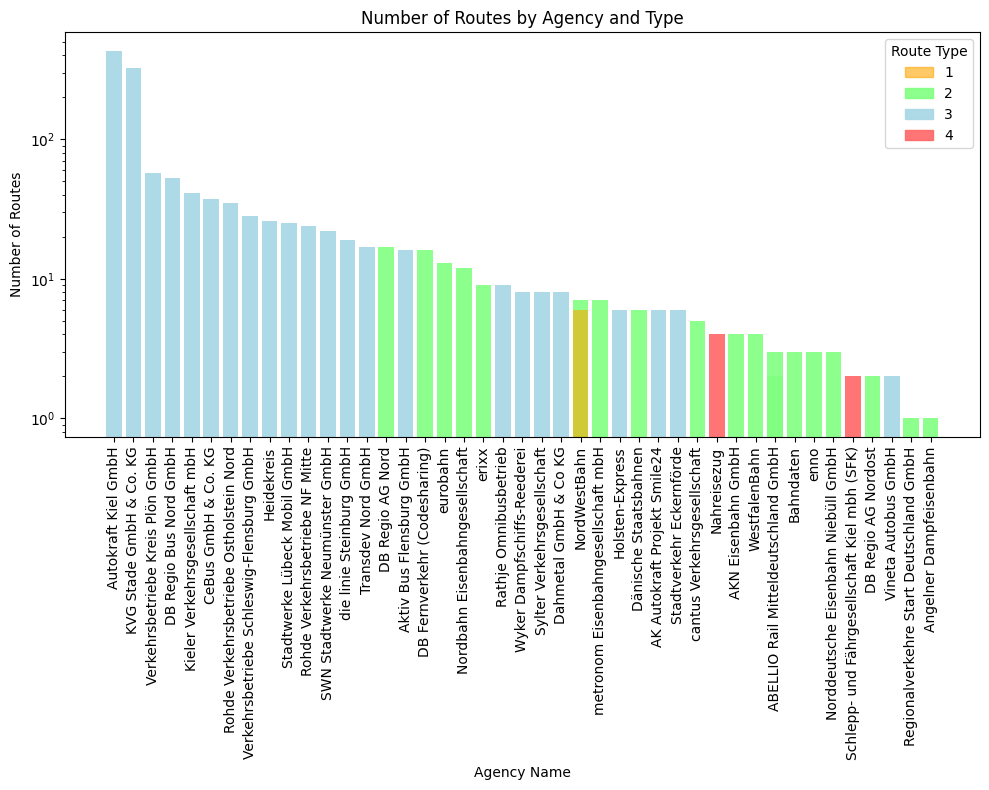

In [29]:
# Create a bar plot
plt.figure(figsize=(10, 8))
bars = plt.bar(agency_routes_type['agency_name'], agency_routes_type['route_count'], color=colors)


# Customize the plot
plt.yscale('log')
plt.title('Number of Routes by Agency and Type')
plt.xlabel('Agency Name')
plt.ylabel('Number of Routes')
plt.xticks(rotation=90)

legend_handles = [Patch(color=color_map[rt], label=rt) for rt in color_map.keys()]
plt.legend(handles=legend_handles, title='Route Type')

plt.tight_layout()

# Show the plot
plt.show()

Highest num of routs provided by Autokraft and KVG and both of they use route type 3(bus). does that mean in that stat, most of goods are being trasported by bus?

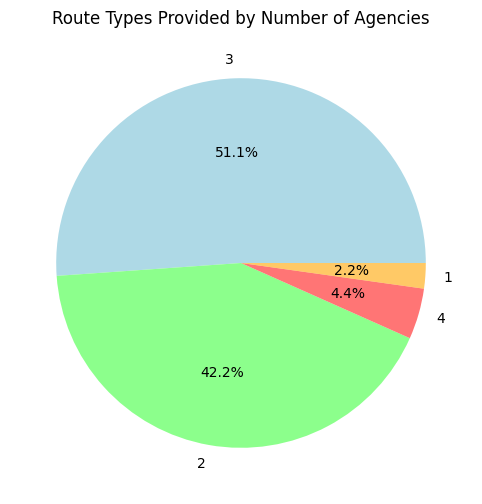

In [30]:
route_type_counts = agency_routes_type['route_type'].value_counts()

colors = [color_map[type_id] for type_id in route_type_counts.index]

plt.figure(figsize=(10,6))
plt.pie(route_type_counts,labels=[3,2,4,1],autopct='%1.1f%%', colors=colors)
plt.title('Route Types Provided by Number of Agencies')
plt.show()

## Task 3

In [31]:
def calculate_path_length(row):
    prev_lat, prev_lon = None, None
    total_distance = 0
    for lat, lon in zip(row['shape_pt_lat'], row['shape_pt_lon']):
        if prev_lat is not None and prev_lon is not None:
            distance = math.sqrt((lon - prev_lon)**2 + (lat - prev_lat)**2)
            total_distance += distance
        prev_lat, prev_lon = lat, lon
    return total_distance

path_lengths = shapes.groupby('shape_id').apply(calculate_path_length).reset_index(name='path_length')
path_lengths['path_length'] = path_lengths['path_length']/1000
path_lengths.head()

<ipython-input-31-2fc9c744f284>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_lengths = shapes.groupby('shape_id').apply(calculate_path_length).reset_index(name='path_length')


,shape_id,path_length
0,1,6.758321
1,2,4.017135
2,3,4.033365
3,4,4.859656
4,5,2.818297


In [32]:
route_trip_data = pd.merge(routes,trips,on='route_id')
route_shape_data = pd.merge(route_trip_data,path_lengths,on='shape_id')
route_shape_data = route_shape_data.groupby('route_id')['path_length'].max().reset_index()
final_data = pd.merge(routes, route_shape_data, on='route_id')

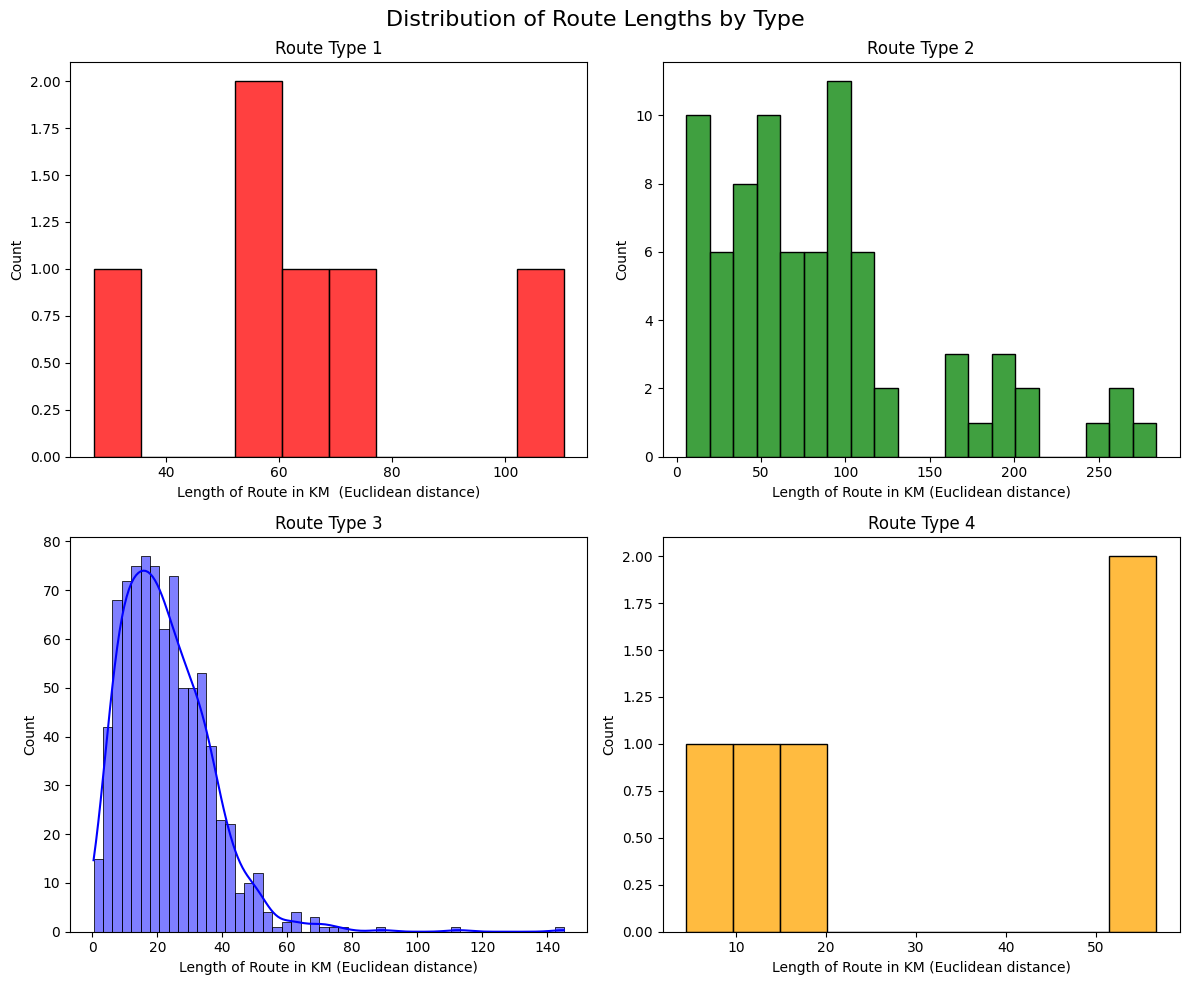

In [40]:
# Create four subsets of the data, one for each route type
route_type_1 = final_data[final_data['route_type'] == 1]
route_type_3 = final_data[final_data['route_type'] == 3]
route_type_4 = final_data[final_data['route_type'] == 4]
route_type_2 = final_data[final_data['route_type'] == 2]

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each route type on its own subplot
sns.histplot(data=route_type_1, x='path_length', bins=10, kde=False, color='red', ax=axes[0])
axes[0].set_title('Route Type 1')
axes[0].set_xlabel('Length of Route in KM  (Euclidean distance)')
axes[0].set_ylabel('Count')

sns.histplot(data=route_type_2, x='path_length', bins=20, kde=False, color='green', ax=axes[1])
axes[1].set_title('Route Type 2')
axes[1].set_xlabel('Length of Route in KM (Euclidean distance)')
axes[1].set_ylabel('Count')

sns.histplot(data=route_type_3, x='path_length', bins=50, kde=True, color='blue', ax=axes[2])
axes[2].set_title('Route Type 3')
axes[2].set_xlabel('Length of Route in KM (Euclidean distance)')
axes[2].set_ylabel('Count')

sns.histplot(data=route_type_4, x='path_length', bins=10, kde=False, color='orange', ax=axes[3])
axes[3].set_title('Route Type 4')
axes[3].set_xlabel('Length of Route in KM (Euclidean distance)')
axes[3].set_ylabel('Count')

# Set the overall title and adjust layout
fig.suptitle('Distribution of Route Lengths by Type', fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

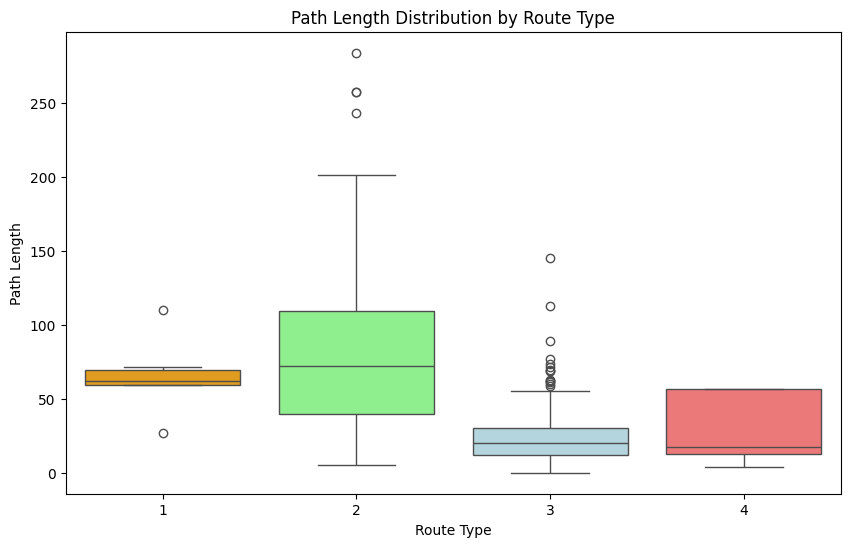

In [33]:
# Box plot to show the distribution of path lengths for each route type
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_data, x='route_type', y='path_length', hue='route_type', palette=color_map,legend=False)
plt.xlabel('Route Type')
plt.ylabel('Path Length')
plt.title('Path Length Distribution by Route Type')
plt.show()

## TASK 4

In [34]:
# Step 1: Merge stop_times with trips to associate each stop with routes
merged_df = stop_times.merge(trips, on='trip_id').merge(routes, on='route_id')


# Step 2: Separate bus and train routes using route_type
# 3 is bus, 2 is train (based on GTFS standard)
bus_routes_df = merged_df[merged_df['route_type'] == 3]  # Replace with correct condition if needed
train_routes_df = merged_df[merged_df['route_type'] == 2]  # Replace with correct condition if needed

# Step 3: Count distinct routes servicing each stop for buses
bus_count_df = bus_routes_df.groupby('stop_id')['route_id'].nunique().reset_index()
bus_count_df.columns = ['stop_id', 'bus_route_count']

# Step 4: Count distinct routes servicing each stop for trains
train_count_df = train_routes_df.groupby('stop_id')['route_id'].nunique().reset_index()
train_count_df.columns = ['stop_id', 'train_route_count']

# Step 5: Combine the bus and train route counts into the stops DataFrame
result_df = stops[['stop_id']].merge(bus_count_df, on='stop_id', how='left').merge(train_count_df, on='stop_id', how='left')

# Replace NaN values with 0 where there are no routes
result_df['bus_route_count'] = result_df['bus_route_count'].fillna(0).astype(int)
result_df['train_route_count'] = result_df['train_route_count'].fillna(0).astype(int)
result_df=pd.merge(result_df,stops,on='stop_id')
result_df=result_df[['stop_id','stop_name','bus_route_count','train_route_count']]


# Display the result
result_df.head()

,stop_id,stop_name,bus_route_count,train_route_count
0,de:03458:14638,Brettorf,0,1
1,de:04012:14517,Bremerhaven-Wulsdorf,0,1
2,de:13076:4259,Pritzier,0,1
3,de:03454:8206,Dörpen,0,2
4,de:03361:22104,Dörverden,0,2


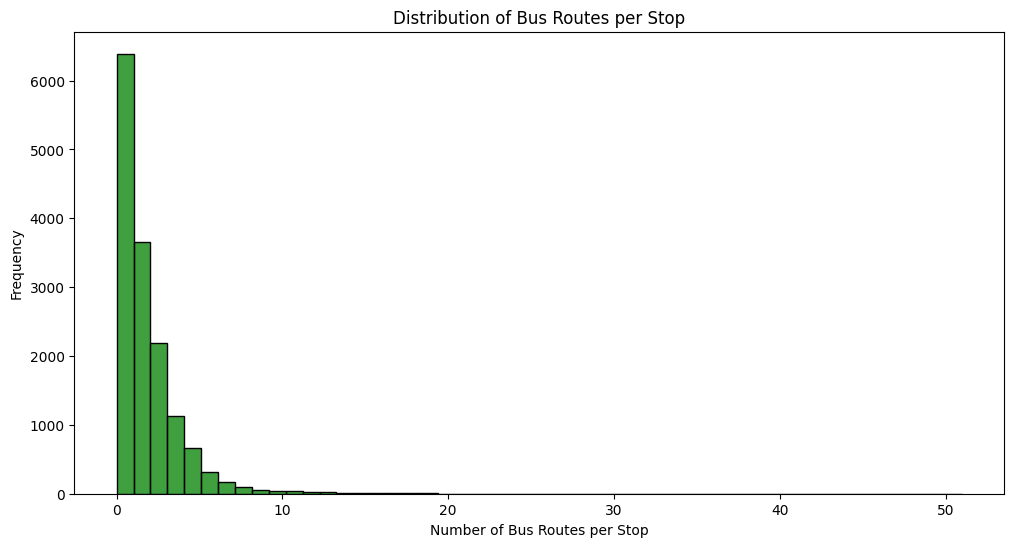

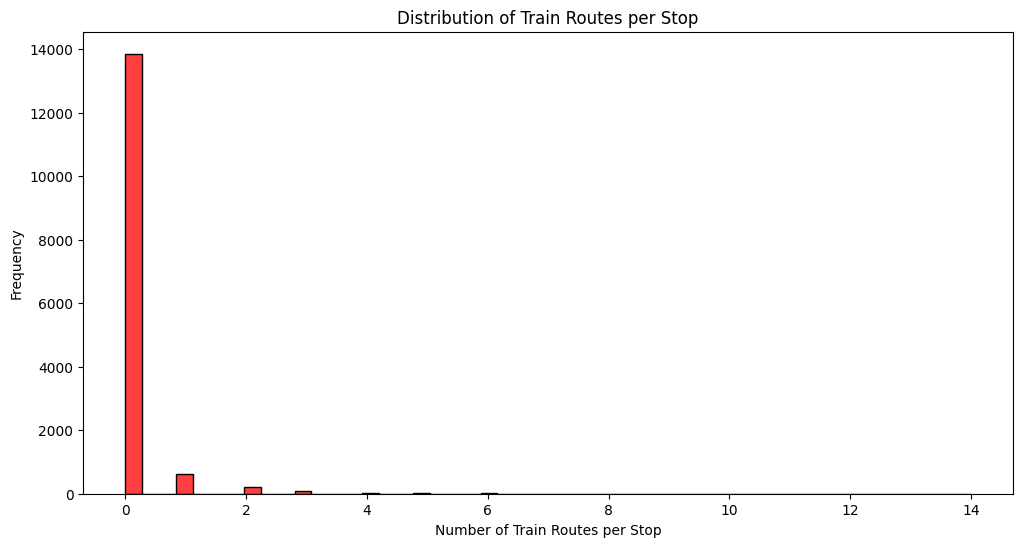

In [39]:
# Distribution of bus routes per stop
plt.figure(figsize=(12, 6))
sns.histplot(result_df['bus_route_count'], bins=50, kde=False, color='green')
plt.xlabel('Number of Bus Routes per Stop')
plt.ylabel('Frequency')
plt.title('Distribution of Bus Routes per Stop')
plt.show()

# Distribution of train routes per stop
plt.figure(figsize=(12, 6))
sns.histplot(result_df['train_route_count'], bins=50, kde=False, color='red')
plt.xlabel('Number of Train Routes per Stop')
plt.ylabel('Frequency')
plt.title('Distribution of Train Routes per Stop')
plt.show()

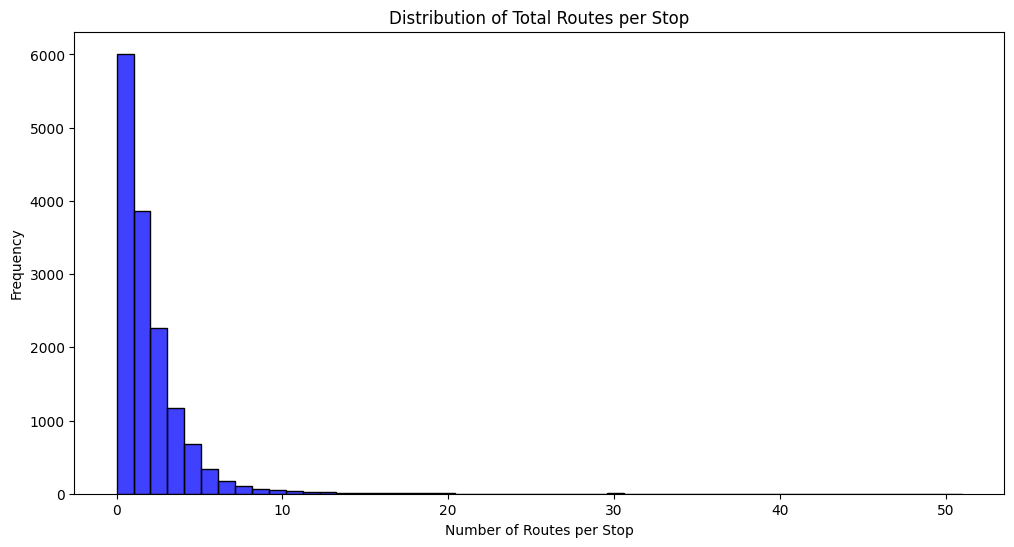

In [35]:
result_df['total_routes'] = result_df['bus_route_count'] + result_df['train_route_count']

# Plot the distribution of the total number of routes per stop
plt.figure(figsize=(12, 6))
sns.histplot(result_df['total_routes'], bins=50, kde=False, color='blue')
plt.xlabel('Number of Routes per Stop')
plt.ylabel('Frequency')
plt.title('Distribution of Total Routes per Stop')
plt.show()

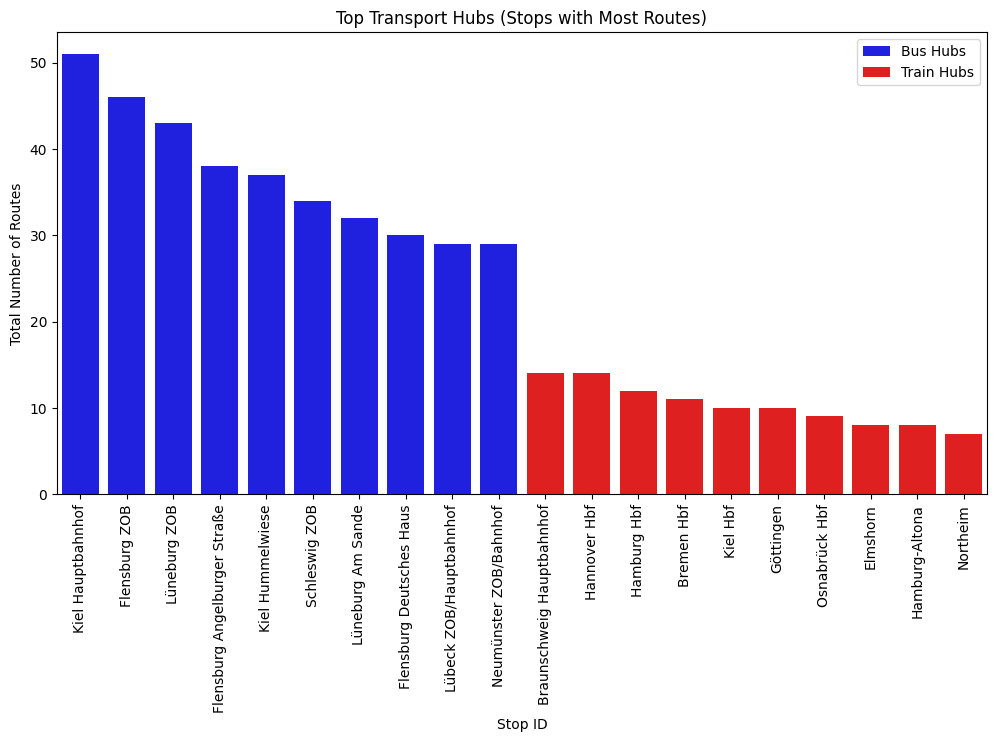

In [36]:
# Identify the hubs: stops with the most routes
# Find the top 'hubs' (stops with the most routes)
bus_hubs = bus_count_df.nlargest(10, 'bus_route_count')
train_hubs = train_count_df.nlargest(10, 'train_route_count')
data_train=pd.merge(train_hubs,stops,on='stop_id')
data_bus= pd.merge(bus_hubs,stops,on='stop_id')


# Plot the top hubs
plt.figure(figsize=(12, 6))
sns.barplot(x='stop_name', y='bus_route_count', data=data_bus, color='blue', label='Bus Hubs')
sns.barplot(x='stop_name', y='train_route_count', data=data_train, color='red', label='Train Hubs')
plt.xlabel('Stop ID')
plt.ylabel('Total Number of Routes')
plt.title('Top Transport Hubs (Stops with Most Routes)')
plt.xticks(rotation=90)
plt.show()


## TASK 5

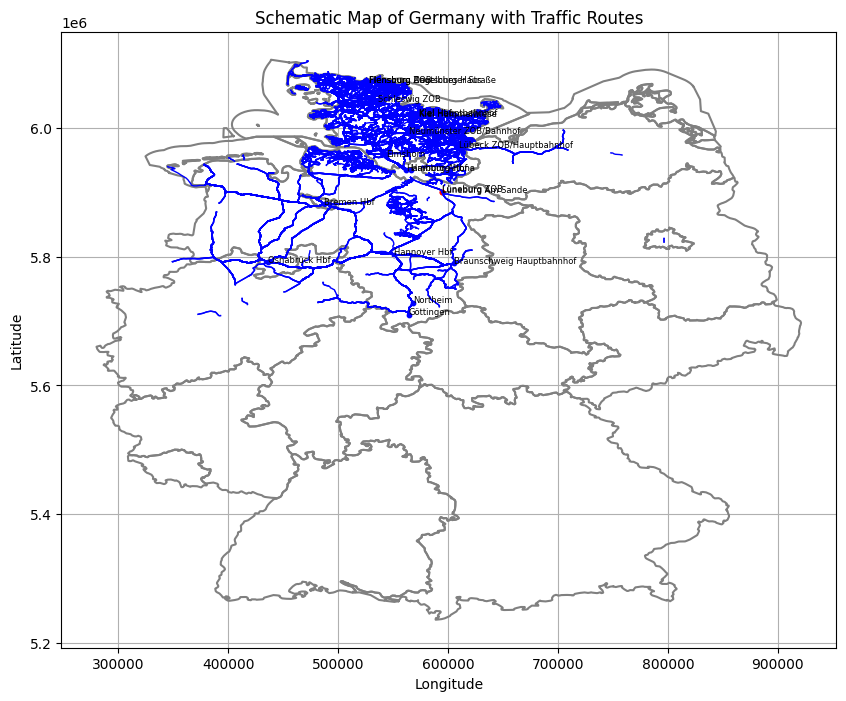

In [37]:
# Load the schematic map of Germany from vg2500.npz
tmp = np.load('/vg2500.npz')
poslist = [tmp[k] for k in tmp.keys()]  # Extract the positional data
del tmp


# Step 1: Plot the schematic map using Matplotlib
plt.figure(figsize=(10, 8))
for pos in poslist:
    plt.plot(*pos, color="#808080")  # Light gray lines for the map

# Step 2: Plot the traffic routes from the shapes DataFrame using Matplotlib
for shape_id, group in shapes.groupby('shape_id'):
    coordinates = list(zip(group['shape_pt_lat'], group['shape_pt_lon']))
    lat, lon = zip(*coordinates)
    plt.plot(lon, lat, color="blue", linewidth=1, label=f'Shape {shape_id}')  # Blue lines for routes

# Plotting bus hubs
for idx, stop in data_bus.iterrows():
    plt.scatter(stop['stop_lon'], stop['stop_lat'], color="red", s=10)  # Red dots for bus stops
    plt.text(stop['stop_lon'], stop['stop_lat'], stop['stop_name'], fontsize=6)  # Label the bus stop

# Plotting train hubs (if you want to plot train hubs too, just repeat this block)
for idx, stop in data_train.iterrows():
    plt.scatter(stop['stop_lon'], stop['stop_lat'], color="blue", s=10)  # Blue dots for train stops
    plt.text(stop['stop_lon'], stop['stop_lat'], stop['stop_name'], fontsize=6)  # Label the train stop

plt.title("Schematic Map of Germany with Traffic Routes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()